<a href="https://colab.research.google.com/github/fberetta8/ML_in_Finance_Spring_2025_ETH/blob/main/Solution8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Pricing in SABR model
The **SABR model** (Stochastic Alpha, Beta, Rho) is a stochastic volatility model commonly used in the pricing of derivatives, especially interest rate options and swaptions.

It models the forward price $F_t$ and its volatility $\sigma_t$ using the following system of SDEs:

$$
\begin{aligned}
dF_t &= \sigma_t F_t^{\beta} dW_t, \\
d\sigma_t &= \nu \sigma_t dB_t, \\
\end{aligned}
$$

with:

- $\beta \in [0, 1]$: controls the dependence of volatility on the price (elasticity).
- $\nu > 0$: volatility of volatility.
- $\rho \in [-1, 1]$: correlation between the two Brownian motions $W_t$ and $B_t$.

The initial volatility is denoted $\alpha = \sigma_0$. We aim to learn the map

$$
(\alpha, \beta, \rho, \nu) \rightarrow \text{price}
$$


# Hagan Approximation

Since the SABR model does **not** admit a closed-form solution for option prices, practitioners typically use the **Hagan et al. approximation** to compute **implied volatilities** under SABR. This implied volatility can then be inserted into the **Black-Scholes formula** to compute prices. In this notebook, we rely on this approximation to simulate data and train a machine learning model to learn the price function.

In [ ]:
# Libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

In [ ]:
# Implied Volatility Formula
def sabr_implied_vol(F, K, T, alpha, beta, rho, nu):
    if F == K:
        term1 = (1 + ((1 - beta)**2 / 24) * (alpha**2 / F**(2 - 2*beta))
                 + (rho * beta * nu * alpha) / (4 * F**(1 - beta))
                 + (nu**2 * (2 - 3 * rho**2)) / 24) * T
        return alpha / (F**(1 - beta)) * (1 + term1)

    log_FK = np.log(F / K)
    z = (nu / alpha) * (F * K)**((1 - beta)/2) * log_FK
    x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
    FK_beta = (F * K)**((1 - beta)/2)

    term1 = (1 + ((1 - beta)**2 / 24) * (log_FK)**2
             + ((1 - beta)**4 / 1920) * (log_FK)**4)
    term2 = (1 + ((1 - beta)**2 / 24) * (alpha**2 / FK_beta**2)
             + (rho * beta * nu * alpha) / (4 * FK_beta)
             + (nu**2 * (2 - 3 * rho**2)) / 24) * T

    return (alpha / (FK_beta * term1)) * (z / x_z) * (1 + term2)

In [ ]:
# Given the implied volatility, we compute the price of a European
# call option using the Black-Scholes formula.

def black_scholes_call(F, K, T, sigma):
    d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return F * norm.cdf(d1) - K * norm.cdf(d2)

In [ ]:
# Generate data

def generate_data(n_samples=10000, F=100.0, K=100.0, T=1.0):
    alphas = np.random.uniform(0.05, 0.5, n_samples)
    betas = np.random.uniform(0.0, 1.0, n_samples)
    rhos = np.random.uniform(-0.99, 0.99, n_samples)
    nus = np.random.uniform(0.1, 1.0, n_samples)

    X = np.stack([alphas, betas, rhos, nus], axis=1)
    y = []

    for alpha, beta, rho, nu in X:
        sigma = sabr_implied_vol(F, K, T, alpha, beta, rho, nu)
        price = black_scholes_call(F, K, T, sigma)
        y.append(price)

    return X, np.array(y)

In [ ]:
# Preprocess data and divide train/test set

X, y = generate_data()
y_log = np.log1p(y) # We apply log-transform, it helps the fit
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test_log, dtype=torch.float32).view(-1, 1)

In [ ]:
# Define model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_t)
    loss = criterion(output, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        val_loss = criterion(model(X_test_t), y_test_t)
        print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Test Loss={val_loss.item():.4f}")

Epoch 0: Train Loss=2.7989, Test Loss=2.6071
Epoch 10: Train Loss=1.9342, Test Loss=1.7794
Epoch 20: Train Loss=1.1519, Test Loss=1.0310
Epoch 30: Train Loss=0.5787, Test Loss=0.5211
Epoch 40: Train Loss=0.3069, Test Loss=0.2842
Epoch 50: Train Loss=0.1404, Test Loss=0.1301
Epoch 60: Train Loss=0.0689, Test Loss=0.0667
Epoch 70: Train Loss=0.0481, Test Loss=0.0488
Epoch 80: Train Loss=0.0418, Test Loss=0.0426
Epoch 90: Train Loss=0.0361, Test Loss=0.0364


In [ ]:
# Predictions on the test set
with torch.no_grad():
    predictions_log = model(X_test_t).numpy()
    predictions = np.expm1(predictions_log)  # reverse log1p

y_test_original = np.expm1(y_test_log)  # undo log1p for plotting

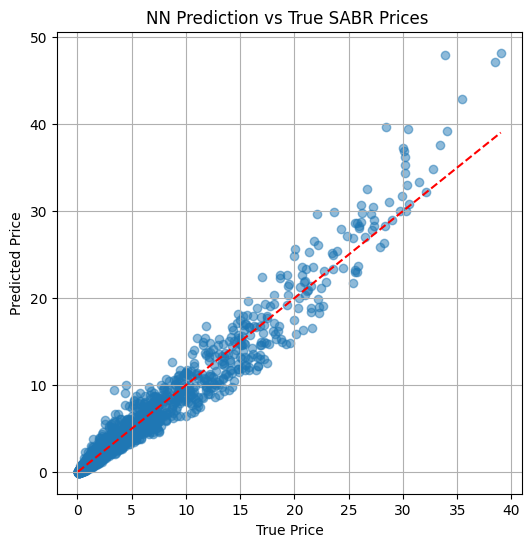

In [ ]:
# Plotting the results
plt.figure(figsize=(6, 6))
plt.scatter(y_test_original, predictions, alpha=0.5)
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)],
         'r--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("NN Prediction vs True SABR Prices ")
plt.grid(True)
plt.show()

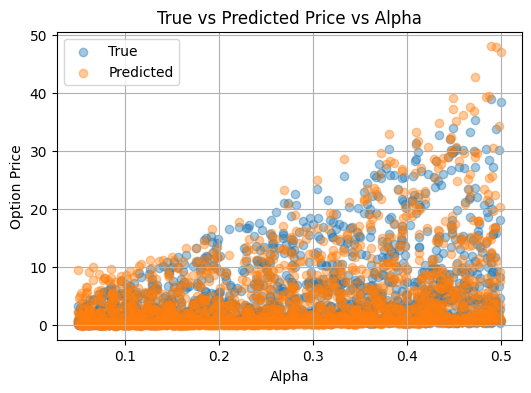

In [ ]:
# Plotting against the parameters
X_test_unscaled = scaler.inverse_transform(X_test)
df_plot = pd.DataFrame(X_test_unscaled, columns=["alpha", "beta", "rho", "nu"])
df_plot["true_price"] = y_test_original
df_plot["predicted_price"] = predictions.flatten()

# Step 3: Plot vs Alpha
plt.figure(figsize=(6, 4))
plt.scatter(df_plot["alpha"], df_plot["true_price"], label="True", alpha=0.4)
plt.scatter(df_plot["alpha"], df_plot["predicted_price"], label="Predicted", alpha=0.4)
plt.xlabel("Alpha")
plt.ylabel("Option Price")
plt.title("True vs Predicted Price vs Alpha")
plt.legend()
plt.grid(True)
plt.show()

# ust change "alpha" to "beta", "rho", or "nu" for the other parameters